In [1]:
import scipy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import io
from scipy import signal
import math
import sys
from IPython.display import display


## Calcular la media entre los electrodos 8, 44, 80, 131 y 185 (el primer electrodo es el 0) y realizar una figura que muestre las frecuencias en el eje Y, los epochs en el eje X, y la potencia usando una escala de color

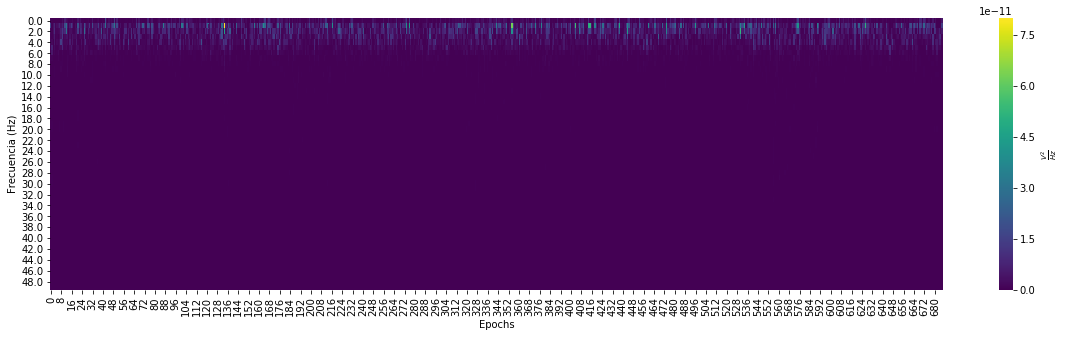

In [2]:
x = (sc.io.loadmat('datasetP/P02.mat'))['data']

epochs = len(x)
electrodes = 256
measures = 201

powersDF = None

plt.subplots(figsize=(20,5))

for i in range(epochs):
    epoch = pd.DataFrame(x[i])
    fourier = sc.signal.welch(epoch.loc[[7, 43, 79, 130, 184]].mean(), nperseg=measures, fs = 201)
    if powersDF is None:
        powersDF = pd.DataFrame(index = np.round(fourier[0], 2))
    powersDF[i] = pd.Series(fourier[1], index = powersDF.index)

sns.heatmap(powersDF[powersDF.index < 50], cmap = 'viridis', cbar_kws = {'label': r'$\frac{V^{2}}{Hz}$'})
plt.xlabel('Epochs')
plt.ylabel('Frecuencia (Hz)')
plt.show()


## Calcular los valores de cada banda de frecuencia, promediados entre los electrodos (todos) y epochs para cada sujeto

In [15]:
deltaRange = [0.0, 4.0]
thetaRange = [4.0, 8.0]
alphaRange = [8.0, 13.0]
betaRange = [13.0, 30.0]
gammaRange = [30.0, 50.0]
classification = ['P'] * 10 + ['S'] * 10
names = list(map((lambda x: ('0'+ str(x))[-2:]), range(1,11)))
# names = ['02']
datasets = ['datasetP/P', 'datasetS/S']
# datasets = ['datasetP/P']

meanDFs = []
subjectsDelta = []
subjectsTheta = []
subjectsAlpha = []
subjectsBeta = []
subjectsGamma = []
subjectsDeltaStDev = []
subjectsThetaStDev = []
subjectsAlphaStDev = []
subjectsBetaStDev = []
subjectsGammaStDev = []
bandNames = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
bandNamesStDev = ['Delta stdev', 'Theta stdev', 'Alpha stdev', 'Beta stdev', 'Gamma stdev']

considerateInBins = []

df = pd.DataFrame(columns = bandNames + bandNamesStDev)

for dataset in datasets:
    for name in names:
        x = (sc.io.loadmat(dataset + name + '.mat'))['data']
        epochs = len(x)
        electrodes = 256
        measures = 201

        epochAcum = None
        epochAcumDF = None
        for i in range(epochs):
            dfe = pd.DataFrame(x[i])
            epoch = dfe.sum()
            if epochAcum is None:
                epochAcumDF = dfe
                epochAcum = epoch
            else:
                epochAcumDF = epochAcumDF.add(dfe)
                epochAcum = epochAcum.add(epoch)
            if np.random.random_sample() * 100 < 5:
                considerateInBins.append(dfe)
        
        epochAcum = epochAcum.divide(epochs * electrodes)
        epochAcumDF = epochAcumDF.divide(epochs)
        meanDFs.append(epochAcumDF)
        fourier = sc.signal.welch(epochAcum, nperseg=measures, fs = 201)
        frecs = fourier[0]
        powers = fourier[1]
        theta = next(i for i, v in enumerate(frecs) if v >= thetaRange[0] and v < thetaRange[1])
        alpha = next(i for i, v in enumerate(frecs) if v >= alphaRange[0] and v < alphaRange[1])
        beta = next(i for i, v in enumerate(frecs) if v >= betaRange[0] and v < betaRange[1])
        gamma = next(i for i, v in enumerate(frecs) if v >= gammaRange[0] and v < gammaRange[1])

        subjectsDelta.append(powers[:theta].mean())
        subjectsTheta.append(powers[theta:alpha].mean())
        subjectsAlpha.append(powers[alpha:beta].mean())
        subjectsBeta.append(powers[beta:gamma].mean())
        subjectsGamma.append(powers[gamma:].mean())

        subjectsDeltaStDev.append(powers[:theta].std())
        subjectsThetaStDev.append(powers[theta:alpha].std())
        subjectsAlphaStDev.append(powers[alpha:beta].std())
        subjectsBetaStDev.append(powers[beta:gamma].std())
        subjectsGammaStDev.append(powers[gamma:].std())

        index = len(subjectsDelta)
        df = df.append((pd.Series( \
            { \
                bandNames[0]: subjectsDelta[-1], \
                bandNames[1]: subjectsTheta[-1], \
                bandNames[2]: subjectsAlpha[-1], \
                bandNames[3]: subjectsBeta[-1], \
                bandNames[4]: subjectsGamma[-1], \
                bandNamesStDev[0]: subjectsDeltaStDev[-1], \
                bandNamesStDev[1]: subjectsThetaStDev[-1], \
                bandNamesStDev[2]: subjectsAlphaStDev[-1], \
                bandNamesStDev[3]: subjectsBetaStDev[-1], \
                bandNamesStDev[4]: subjectsGammaStDev[-1] \
            })).rename('Subject ' + names[(index - 1) % 10] + ' ' + classification[index - 1]))
display(df)
df.to_csv('../tp3/mean-stdev-raw.csv')

,Delta,Theta,Alpha,Beta,Gamma,Delta stdev,Theta stdev,Alpha stdev,Beta stdev,Gamma stdev
Subject 01 P,1.933618e-17,8.238647e-17,4.174321e-18,1.170747e-18,5.460780e-20,1.142105e-17,6.589826e-17,2.710178e-18,8.936329e-19,1.863571e-19
Subject 02 P,4.933276e-17,1.592153e-17,1.255062e-18,3.657378e-19,3.174904e-20,4.813444e-17,1.978622e-17,1.150244e-18,2.859566e-19,1.166969e-19
Subject 03 P,8.579026e-17,8.927993e-18,2.530623e-18,7.835320e-19,3.328533e-20,9.794422e-17,6.492333e-18,1.402481e-18,7.929307e-19,1.504384e-19
Subject 04 P,6.627825e-18,3.045901e-18,1.437712e-19,1.659174e-20,3.063610e-22,7.433970e-18,1.773314e-18,1.366289e-19,1.500193e-20,9.685074e-22
Subject 05 P,6.515051e-17,3.555999e-16,3.639976e-17,1.450163e-17,3.942575e-19,5.277000e-17,2.226792e-16,2.514125e-17,1.591116e-17,1.636181e-18
Subject 06 P,2.325545e-18,5.050404e-19,7.865331e-20,8.049402e-21,8.603865e-22,1.948442e-18,3.448960e-19,4.835214e-20,6.797363e-21,3.381717e-21
Subject 07 P,5.181191e-17,8.452204e-17,1.780590e-17,8.251151e-19,3.350370e-20,6.014960e-17,6.458679e-17,1.591448e-17,1.064565e-18,1.135538e-19
Subject 08 P,3.158920e-16,1.117502e-16,4.583215e-18,3.090276e-19,1.061924e-20,3.360102e-16,9.565384e-17,3.393934e-18,2.014890e-19,3.483724e-20
Subject 09 P,8.936738e-15,2.633642e-15,2.294612e-16,9.710163e-16,3.550572e-17,6.820503e-15,2.063029e-15,1.090734e-16,1.146969e-15,1.689142e-16
Subject 10 P,3.390567e-18,1.906765e-19,4.650550e-20,9.425921e-21,4.121588e-22,3.849416e-18,2.762696e-19,3.327891e-20,8.191413e-21,1.356825e-21


## Tomar la potencia de cada sujeto en la banda Alpha y graficar cada uno de los graficos categóricos de seaborn

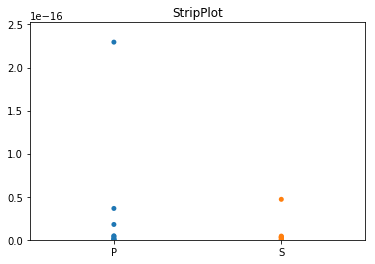

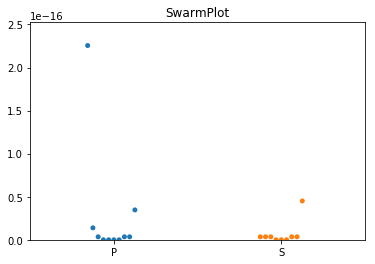

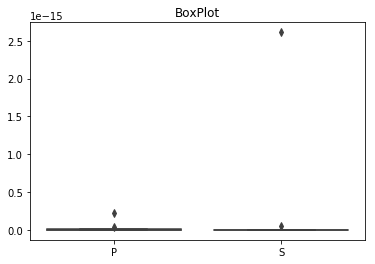

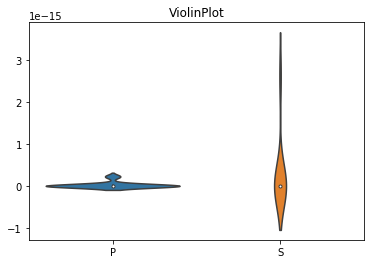

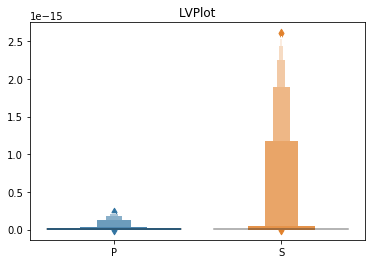

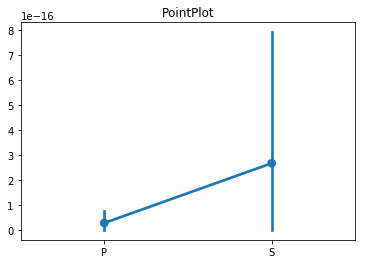

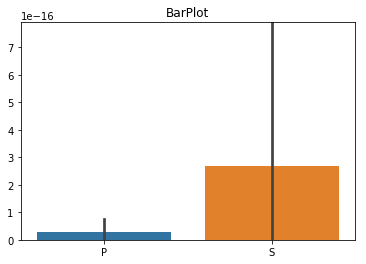

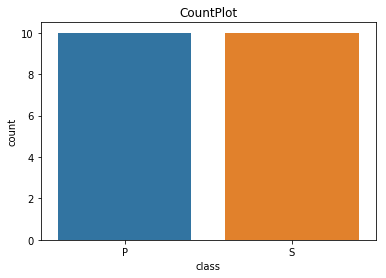

In [16]:
df = pd.DataFrame({'P': subjectsAlpha[:10], 'S': subjectsAlpha[10:]})
plotNames = ['StripPlot', 'SwarmPlot', 'BoxPlot', 'ViolinPlot', 'LVPlot', 'PointPlot', 'BarPlot', 'CountPlot']
plots = [sns.stripplot, sns.swarmplot, sns.boxplot, sns.violinplot, sns.lvplot, sns.pointplot, sns.barplot]

for i, plotClass in enumerate(plots):
    fig = plotClass(data = df)
    if (i < 2):
        fig.set_ylim([0, df['P'].max() * 1.1])
    plt.title(plotNames[i])
    plt.show()

df_new = pd.DataFrame({'class': ['P'] * 10 + ['S'] * 10, 'values': subjectsAlpha})
sns.countplot(x = 'class', data = df_new)
plt.title(plotNames[-1])
plt.show()


## ¿Cuál recomendaría para graficar y comparar distribuciones?
Para comparar las distribuciones recomendamos utilizar violin plot. En este gráfico se visualiza la distribución de los datos y su probabilidad de densidad, ya que es una combinación entre un density plot y un box plot. En el primer tipo de gráfico vemos la distrubición de los datos, mientras que el segundo nos da información sobre la media y outliers (entre otros).

En un violin plot, las secciones más anchas representan mayor probabilidad de que los datos se ubiquen en dicha región; las secciones más angostas señalan una menor probablidad de que esto suceda.

Podemos observar que la banda de frecuencia alfa para la categoría de pacientes S presenta datos anómalos de mayor valor que los pacientes P, mientras que en estos últimos la probabilidad de que la potencia de los electrodos esté en la región determinada por la media es más alta que en la categoría S (aquí las potencias están más distribuidas). Podemos suponer que la media (representada por el punto blanco) de ambas categorías para la banda alfa es similar, mientras que la varianza es distinta (pues las regiones tienen diferentes proporciones).


## Para cada banda de frecuencia, graficarla y realizar un test estadístico apropiado

Como mencionamos en el item anterior, consideramos que el violin plot es el gráfico más adecuado para nuestro análisis. Además, al pie de cada uno, mostramos el resultado de haber ejecutado los tests de Kolmogorov-Smirnov en 2 muestras, Welch, y One-way Anova, sobre cada una de las bandas.

El test de Kolmogorov-Smirnov evalúa si dos muestras provienen de la misma distribución, por lo que si obtenemos un p-value alto, no podemos rechazar la hipótesis de que las distribuciones sean iguales. Para el caso de Welch y one-way Anova, el objetivo es rechazar que las muestras P y S tienen igual media. Cabe destacar que este último test asume que las muestras tienen igual varianza, mientras que el test de Welch no requiere que tengan el mismo valor.


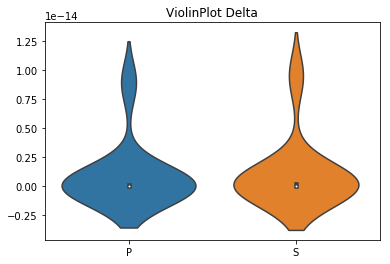

,Statistic,p-value
Kolmogorov-Smirnov,0.200000,0.974789
Welch,-0.107767,0.915376
One-Way Anova,-0.107767,0.915373


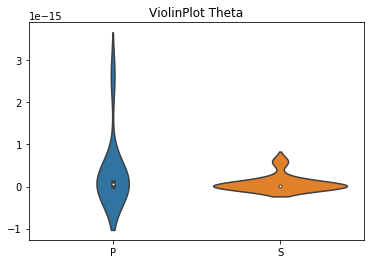

,Statistic,p-value
Kolmogorov-Smirnov,0.400000,0.312853
Welch,0.932639,0.373094
One-Way Anova,0.932639,0.363349


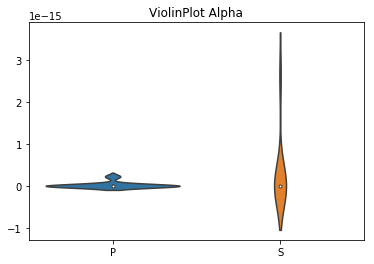

,Statistic,p-value
Kolmogorov-Smirnov,0.30000,0.675078
Welch,-0.91058,0.385916
One-Way Anova,-0.91058,0.374550


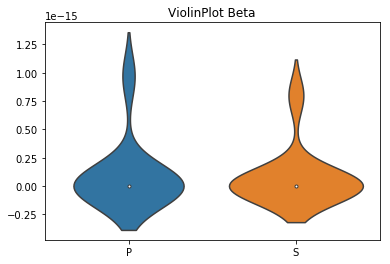

,Statistic,p-value
Kolmogorov-Smirnov,0.300000,0.675078
Welch,0.137015,0.892596
One-Way Anova,0.137015,0.892540


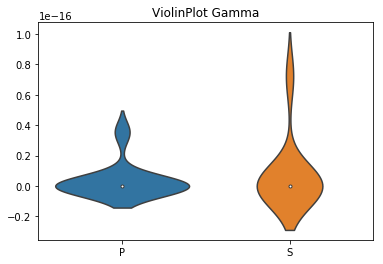

,Statistic,p-value
Kolmogorov-Smirnov,0.300000,0.675078
Welch,-0.455586,0.656152
One-Way Anova,-0.455586,0.654136


In [20]:
formula = 'Value ~ C(Band) + C(Type) + C(Band):C(Type)'
subjectsBands = [subjectsDelta, subjectsTheta, subjectsAlpha, subjectsBeta, subjectsGamma]
subjectsBandsStDev = [subjectsDeltaStDev, subjectsThetaStDev, subjectsAlphaStDev, subjectsBetaStDev, subjectsGammaStDev]
testReturnNames = ['Statistic', 'p-value'] 

dfGeneral = pd.DataFrame()
for i, subjectsBand in enumerate(subjectsBands):
    testResults = []
    dfTest = pd.DataFrame(columns = testReturnNames)
    df = pd.DataFrame({'P': subjectsBand[:10], 'S': subjectsBand[10:]})
    sns.violinplot(data = df)
    plt.title('ViolinPlot ' + bandNames[i])
    plt.show()
    
    t, p = sc.stats.ks_2samp(df['P'], df['S'])
#     print ('Kolmogorov-Smirnov en 2 muestras')
#     print t, p
    testResults.append({'name': 'Kolmogorov-Smirnov','statistic': t, 'p-value': p})
    t, p = sc.stats.ttest_ind(df['P'], df['S'], equal_var = False)
#     print 'welch'
#     print t, p
    testResults.append({'name': 'Welch', 'statistic': t, 'p-value': p})
    s, p = sc.stats.f_oneway(df['P'], df['S'])
#     print 'one way'
#     print s, p
    testResults.append({'name': 'One-Way Anova', 'statistic': t, 'p-value': p})
    
    for i in range(len(testResults)):
        dfTest = dfTest.append((pd.Series( \
        { \
            testReturnNames[0]: testResults[i]['statistic'], \
            testReturnNames[1]: testResults[i]['p-value'], \
        })).rename(testResults[i]['name']))

    display(dfTest)

## Repetir para los valores normalizados
### 1) Calcular los valores de cada banda de frecuencia, promediados entre los electrodos (todos) y epochs para cada sujeto
### 2) Para cada banda de frecuencia, graficarla y realizar un test estadístico apropiado

In [ ]:
normalizedDelta = []
normalizedTheta = []
normalizedAlpha = []
normalizedBeta = []
normalizedGamma = []
normalizedBands = [normalizedDelta, normalizedTheta, normalizedAlpha, normalizedBeta, normalizedGamma]
normalizedDeltaStDev = []
normalizedThetaStDev = []
normalizedAlphaStDev = []
normalizedBetaStDev = []
normalizedGammaStDev = []
normalizedBandsStDev = [normalizedDeltaStDev, normalizedThetaStDev, normalizedAlphaStDev, normalizedBetaStDev, normalizedGammaStDev]

df = pd.DataFrame(columns = bandNames + bandNamesStDev)

for i, _ in enumerate(subjectsDelta):
    totalSum = 0
    for subjectsBand in subjectsBands:
        totalSum += subjectsBand[i]
    for j, normalizedBand in enumerate(normalizedBands):
        normalizedBand.append(subjectsBands[j][i] / float(totalSum))

    for subjectsBandStDev in subjectsBandsStDev:
        totalSum += subjectsBandStDev[i]
    for j, normalizedBandStDev in enumerate(normalizedBandsStDev):
        normalizedBandStDev.append(subjectsBandsStDev[j][i] / float(totalSum))

for i in range(len(normalizedBands[0])):
    df = df.append((pd.Series( \
        { \
            bandNames[0]: normalizedDelta[i], \
            bandNames[1]: normalizedTheta[i], \
            bandNames[2]: normalizedAlpha[i], \
            bandNames[3]: normalizedBeta[i], \
            bandNames[4]: normalizedGamma[i], \
            bandNamesStDev[0]: normalizedDeltaStDev[i], \
            bandNamesStDev[1]: normalizedThetaStDev[i], \
            bandNamesStDev[2]: normalizedAlphaStDev[i], \
            bandNamesStDev[3]: normalizedBetaStDev[i], \
            bandNamesStDev[4]: normalizedGammaStDev[i] \
        })).rename('Subject ' + names[i % 10] + ' ' + classification[i]))

display(df)
df.to_csv('../tp3/mean-stdev-norm.csv')


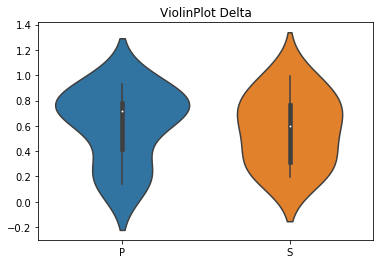

,Statistic,p-value
Kolmogorov-Smirnov,0.300000,0.675078
Welch,0.291545,0.773971
One-Way Anova,0.084999,0.773967


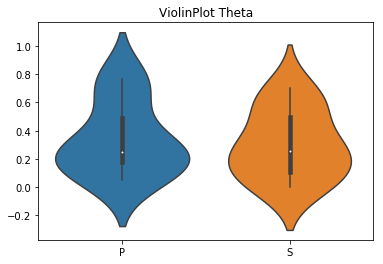

,Statistic,p-value
Kolmogorov-Smirnov,0.200000,0.974789
Welch,0.324586,0.749254
One-Way Anova,0.105356,0.749236


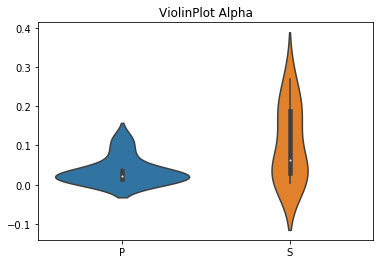

,Statistic,p-value
Kolmogorov-Smirnov,0.50000,0.110840
Welch,-2.13069,0.055931
One-Way Anova,4.53984,0.047160


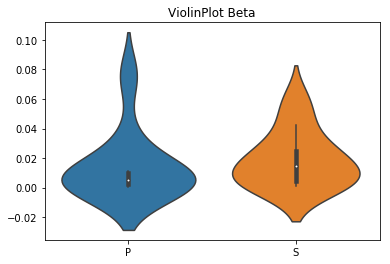

,Statistic,p-value
Kolmogorov-Smirnov,0.300000,0.675078
Welch,-0.496661,0.625681
One-Way Anova,0.246672,0.625439


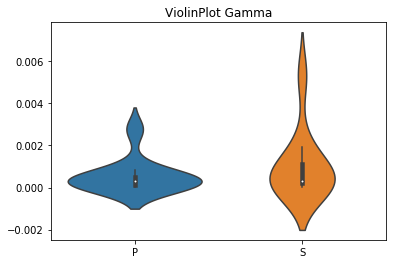

,Statistic,p-value
Kolmogorov-Smirnov,0.200000,0.974789
Welch,-0.822250,0.425462
One-Way Anova,0.676095,0.421694


In [22]:
dfGeneral = pd.DataFrame()
for i, normalizedBand in enumerate(normalizedBands):
    testResults = []
    dfTest = pd.DataFrame(columns = testReturnNames)
    df = pd.DataFrame({'P': normalizedBand[:10], 'S': normalizedBand[10:]})
    sns.violinplot(data = df)
    plt.title('ViolinPlot ' + bandNames[i])
    plt.show()
    t, p = sc.stats.ks_2samp(df['P'], df['S'])
    testResults.append({'name': 'Kolmogorov-Smirnov','statistic': t, 'p-value': p})
#     print ('ks_2sample')
#     print t, p
    t, p = sc.stats.ttest_ind(df['P'], df['S'], equal_var = False)
    testResults.append({'name': 'Welch', 'statistic': t, 'p-value': p})
#     print 'welch'
#     print t, p
    s, p = sc.stats.f_oneway(df['P'], df['S'])
    testResults.append({'name': 'One-Way Anova', 'statistic': s, 'p-value': p})
#     print 'one way'
#     print s, p
    
    for i in range(len(testResults)):
        dfTest = dfTest.append((pd.Series( \
        { \
            testReturnNames[0]: testResults[i]['statistic'], \
            testReturnNames[1]: testResults[i]['p-value'], \
        })).rename(testResults[i]['name']))

    display(dfTest)

## Computar una medida de información intra-electrodo. Calcular la media entre canales y epochs para cada sujeto. Realizar el gráfico elegido en la sección anterior, acompañado del test estadístico apropiado

In [ ]:
def scottRule(powers):
    ampMax = max(powers)
    ampMin = min(powers)
    interval = ampMax-ampMin
    n = math.ceil(float(interval) / (3.5 * np.std(powers) * (len(powers) ** (-1 / 3.0))))
    return n, float(interval) / n

nMean = None
nAcum = []
maxAcum = []
minAcum = []
for epoch in considerateInBins:
    fourier = sc.signal.welch(epoch, nperseg=measures, fs = 201)
    for f in fourier[1]:
        n, _ = scottRule(powers)
        nAcum.append(n)
        maxAcum.append(max(f))
        minAcum.append(min(f))
nMean = np.mean(nAcum)
maxPower = np.mean(maxAcum)
minPower = np.mean(minAcum)


In [ ]:
interval = maxPower - minPower
var = nMean
nMean = 1000
step = interval / nMean

def bineador(power):
    val = int(power / step)
    if val > nMean - 1:
        return int(nMean - 1)
    return val

dfEntropies = None

for it, meanEpoch in enumerate(meanDFs):
    fourier = sc.signal.welch(meanEpoch, nperseg=measures, fs = 201)
    entropiesByElectrode = []
    for powers in fourier[1]:
        series = list(map(bineador, powers))
        probabilityOfXs = [(series.count(i)/float(len(series))) for i in list(range(int(nMean)))]
        entropy = sc.stats.entropy(probabilityOfXs)
        entropiesByElectrode.append(entropy)
    dfAux = pd.DataFrame({classification[it] + str(it % 10): entropiesByElectrode})
    if dfEntropies is None:
        dfEntropies = dfAux
    else:
        dfEntropies[classification[it] + str(it % 10)] = dfAux

display(dfEntropies)
nMean = var


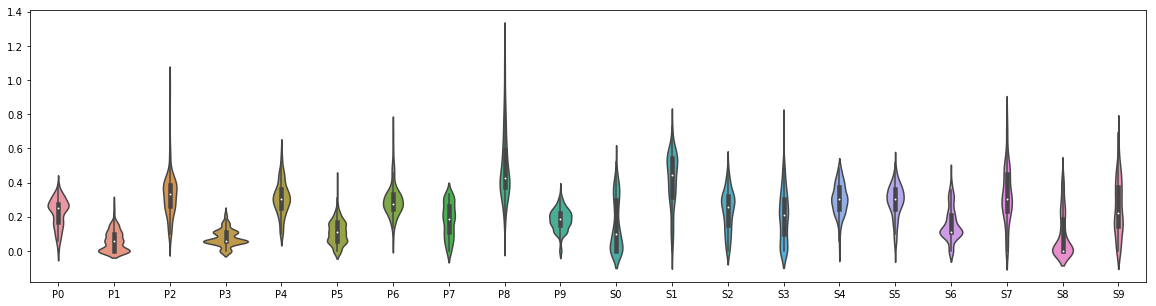

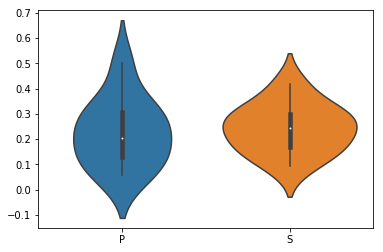

NameError: name 'testResultNames' is not defined

In [18]:
plt.subplots(figsize = (20,5))
sns.violinplot(data = dfEntropies)
plt.show()

dfMean = dfEntropies.mean()
dfMeanEntropy = pd.DataFrame({'P': dfMean[:10], 'S': dfMean[10:]})
sns.violinplot(data = dfMeanEntropy)
plt.show()

testResults = []
dfTest = pd.DataFrame(columns = testResultNames)

t, p = sc.stats.ks_2samp(dfMeanEntropy['P'], dfMeanEntropy['S'])
testResults.append({'name': 'Kolmogorov-Smirnov','statistic': t, 'p-value': p})
# print ('ks_2sample')
# print t, p
t, p = sc.stats.ttest_ind(dfMeanEntropy['P'], dfMeanEntropy['S'], equal_var = False)
testResults.append({'name': 'Welch', 'statistic': t, 'p-value': p})
# print 'welch'
# print t, p
s, p = sc.stats.f_oneway(dfMeanEntropy['P'], dfMeanEntropy['S'])
testResults.append({'name': 'One-Way Anova', 'statistic': s, 'p-value': p})
# print 'one way'
# print s, p

for i in range(len(testResults)):
        dfTest = dfTest.append((pd.Series( \
        { \
            testReturnNames[0]: testResults[i]['statistic'], \
            testReturnNames[1]: testResults[i]['p-value'], \
        })).rename(testResults[i]['name']))

display(dfTest)

meanElectrodesEntropyP = dfEntropies[['P0','P1','P2','P3','P4','P5','P6','P7','P8','P9']].T.mean()
meanElectrodesEntropyS = dfEntropies[['S0','S1','S2','S3','S4','S5','S6','S7','S8','S9']].T.mean()

dfMeanEntropy = pd.DataFrame({'P': meanElectrodesEntropyP, 'S': meanElectrodesEntropyS})
sns.violinplot(data = dfMeanEntropy)
plt.show()

testResults = []
dfTest = pd.DataFrame(columns = testResultNames)
t, p = sc.stats.ks_2samp(dfMeanEntropy['P'], dfMeanEntropy['S'])
testResults.append({'name': 'Kolmogorov-Smirnov','statistic': t, 'p-value': p})
# print ('ks_2sample')
# print t, p
t, p = sc.stats.ttest_ind(dfMeanEntropy['P'], dfMeanEntropy['S'], equal_var = False)
testResults.append({'name': 'Welch', 'statistic': t, 'p-value': p})
# print 'welch'
# print t, p
s, p = sc.stats.f_oneway(dfMeanEntropy['P'], dfMeanEntropy['S'])
testResults.append({'name': 'One-Way Anova', 'statistic': s, 'p-value': p})
# print 'one way'
# print s, p

for i in range(len(testResults)):
        dfTest = dfTest.append((pd.Series( \
        { \
            testReturnNames[0]: testResults[i]['statistic'], \
            testReturnNames[1]: testResults[i]['p-value'], \
        })).rename(testResults[i]['name']))

display(dfTest)

In [11]:
means = dfEntropies.mean()
stDevs = dfEntropies.std()
df = pd.DataFrame({'Mean': means, 'StDev': stDevs})
display(df)
df.to_csv('../tp3/mean-stdev-intra.csv')


,Mean,StDev
P0,0.225361,0.084785
P1,0.058432,0.060252
P2,0.325377,0.126225
P3,0.077333,0.048603
P4,0.308818,0.099080
P5,0.109643,0.069237
P6,0.297301,0.097920
P7,0.180963,0.101429
P8,0.499968,0.206929
P9,0.184237,0.064690


## Repetir para una medida inter-electrodo

In [12]:
# x = (sc.io.loadmat(dataset + name + '.mat'))['data']
x = (sc.io.loadmat('datasetP/' + 'P02' + '.mat'))['data']
epoch0p2 = pd.DataFrame(x[0])

fourierX = sc.signal.welch(epoch0p2.loc[[7]].mean(), nperseg=measures, fs = 201)
powersX = fourierX[1]
ampMaxX = max(powersX)
ampMinX = min(powersX)
intervalX = ampMaxX-ampMinX
nX = math.ceil(intervalX/(3.5*(len(powersX)**(-1/3))*np.std(powersX)))
stepX = intervalX/nX
seriesX = list(map(lambda z: int(z/stepX), powersX))
probabilityOfXs = [(seriesX.count(xi)/float(len(seriesX))) for xi in seriesX]

fourierY = sc.signal.welch(epoch0p2.loc[[8]].mean(), nperseg=measures, fs = 201)
powersY = fourierY[1]
ampMaxY = max(powersY)
ampMinY = min(powersY)
intervalY = ampMaxY-ampMinY
nY = math.ceil(intervalY/(3.5*(len(powersY)**(-1/3))*np.std(powersY)))
stepY = intervalY/nY
seriesY = list(map(lambda z: int(z/stepY), powersY))
probabilityOfYs = [(seriesY.count(yi)/float(len(seriesY))) for yi in seriesY]

# Asumimos P(xi) independiente de P(yj) para todo i,j.
# Luego, P(x,y) = P(x)*P(y)
# entropy = sc.stats.entropy(probabilityOfXs) * sc.stats.entropy(probabilityOfYs)
entropy = 0
for pxi in probabilityOfXs:
    for pyj in probabilityOfYs:
        entropy += pxi*pyj*math.log(pxi*pyj)
entropy = -entropy
print(entropy)

2264.75590163
